数据准备与导入

In [35]:
import pandas as pd  # 导入 pandas 库，用于数据处理和分析

# 使用 pandas 的 read_excel 方法读取 Excel 文件
df = pd.read_excel('text_analysis_ad_sample.xlsx', index_col=0)

# 打印读取的 DataFrame，方便查看数据内容和结构
df
#显示前5行数据
df.head()

,index,商品名称,商品类别,出版年,广告文本,广告标题
0,1596,五华牌香烟[May Blossom],烟草制品,1932,兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟 二十枝装每包售国币大洋二角 五十枝装每罐售国币...,"五华牌香烟,""兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟"""
1,5627,韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People],药品,1918,讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...,韦廉士红色清导丸:'讲求卫生为人生本性天理固然也'
2,13532,大炮台香烟[Three Castles Cigarettes],烟草制品,1935,"香味馥郁,不让名花 另有三炮台出售","大炮台香烟,""香味馥郁 不让名花"""
3,1133,婴孩自己药片[Baby's Own],药品,1930,差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...,"婴孩自己药片,""差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片"""
4,3146,亚士北罗药片[Aspro],药品,1933,何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...,"亚士北罗药片,""妇女之腻友"""


文本分词处理

In [36]:
#分词
import jieba #中文分词
## 定义文本清洗函数
def clean_text(text):
    words = jieba.lcut(text)
    return' '.join(words) #将分词结果用空格连接成字符串
test = df['广告文本'][0] #从DataFrame的"广告文本"列中提取第一个广告文本作为测试样本
clean_text(test)  #测试清洗函数，输出分词结果
df['广告文本分词'] = df['广告文本'].apply(clean_text)  # 对 DataFrame 的"广告文本"列应用分词函数，并将结果存储在新列"广告文本分词"中
df  
#显示前5行数据
df.head()  # 显示 DataFrame 的前5行数据，方便检查分词结果和数据结构

,index,商品名称,商品类别,出版年,广告文本,广告标题,广告文本分词
0,1596,五华牌香烟[May Blossom],烟草制品,1932,兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟 二十枝装每包售国币大洋二角 五十枝装每罐售国币...,"五华牌香烟,""兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟""",兰勃 脱白 脱勒 公司 五华 牌 香烟 佛及 尼埃 香烟 二十 枝装 每包 ...
1,5627,韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People],药品,1918,讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...,韦廉士红色清导丸:'讲求卫生为人生本性天理固然也',讲求 卫生 为 人生 本性 天理 固然 也 人生 首贵 逐日 大便 通畅 有序 为 天然...
2,13532,大炮台香烟[Three Castles Cigarettes],烟草制品,1935,"香味馥郁,不让名花 另有三炮台出售","大炮台香烟,""香味馥郁 不让名花""","香味 馥郁 , 不让 名花 另 有 三 炮台 出售"
3,1133,婴孩自己药片[Baby's Own],药品,1930,差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...,"婴孩自己药片,""差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片""",差肩 儿女 秀慧 康强 闽有 佳音 讃 羡 婴孩 自己 药片 每年 此际 小儿 ...
4,3146,亚士北罗药片[Aspro],药品,1933,何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...,"亚士北罗药片,""妇女之腻友""",何以 亚士 北罗 是 妇女 们 的 腻友 ？ 各国 妇女 力证 亚士 北罗 药片 是 她们 ...


In [37]:
# 将 clean_text 函数应用于 '广告文本' 列
test = df['广告文本'][0]  # 从 DataFrame 的 '广告文本' 列中提取第一个广告文本作为测试样本
cleaned_text = clean_text(test)  # 调用 clean_text 函数对文本进行分词和清洗
print(cleaned_text)  # 打印清洗后的文本结果
#显示前5行数据
df.head()  # 显示 DataFrame 的前5行数据，方便检查分词结果和数据结构

兰勃 脱白 脱勒 公司   五华 牌 香烟   佛及 尼埃 香烟     二十 枝装 每包 售 国币 大洋 二角   五十 枝装 每罐 售 国币 大洋   五角


,index,商品名称,商品类别,出版年,广告文本,广告标题,广告文本分词
0,1596,五华牌香烟[May Blossom],烟草制品,1932,兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟 二十枝装每包售国币大洋二角 五十枝装每罐售国币...,"五华牌香烟,""兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟""",兰勃 脱白 脱勒 公司 五华 牌 香烟 佛及 尼埃 香烟 二十 枝装 每包 ...
1,5627,韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People],药品,1918,讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...,韦廉士红色清导丸:'讲求卫生为人生本性天理固然也',讲求 卫生 为 人生 本性 天理 固然 也 人生 首贵 逐日 大便 通畅 有序 为 天然...
2,13532,大炮台香烟[Three Castles Cigarettes],烟草制品,1935,"香味馥郁,不让名花 另有三炮台出售","大炮台香烟,""香味馥郁 不让名花""","香味 馥郁 , 不让 名花 另 有 三 炮台 出售"
3,1133,婴孩自己药片[Baby's Own],药品,1930,差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...,"婴孩自己药片,""差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片""",差肩 儿女 秀慧 康强 闽有 佳音 讃 羡 婴孩 自己 药片 每年 此际 小儿 ...
4,3146,亚士北罗药片[Aspro],药品,1933,何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...,"亚士北罗药片,""妇女之腻友""",何以 亚士 北罗 是 妇女 们 的 腻友 ？ 各国 妇女 力证 亚士 北罗 药片 是 她们 ...


文本预处理

In [38]:
#语料库准备
from gensim.test.utils import common_texts 
common_texts
[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]  #  # 示例语料库，包含多个文本，每个文本是一个词语列表
corpus = df['广告文本'].apply(lambda x: x.split()).tolist() # 切分词语
    


词嵌入模型

In [39]:

# 自己训练词嵌入模型
from gensim.models import Word2Vec #训练 Word2Vec 模型
# 使用包含目标词语的语料
corpus = [
    ["医生", "治疗", "病人", "的", "疼痛"],
    ["神经", "系统", "与", "疼痛", "感知", "有关"],
    ["伤风", "会", "引起", "头痛", "和", "身体", "疼痛"]
]
# 训练词嵌入模型
model = Word2Vec(
    corpus, #训练语料
    window = 5, #训练算法考虑的当前词语与预测词语在一个句子中的最大距离（窗口大小）
    vector_size = 100, #自定义训练向量维度
    min_count = 1, #忽略所有总频数低于这个值的词语
    epochs = 10
)

# 保存训练好的模型
model.save('Word2vec_ad.model')

# 查看词向量
word_list = model.wv.index_to_key #获取词汇表
word_vectors = model.wv[word_list] #获取词向量

# 打印前5个词及其向量表示
#for word, vector in list(zip(word_list, word_vectors))[:5]:
#   print(f'{word}:{vector}')

In [40]:

#计算词语相似度
## 使用余弦相似度 wv 度量词对之间的语义接近度
## 余弦相似度的取值介于[-1，1]之间，-1表示语义完全相反，1表示语义完全相同，0表示毫无关系
print(model.wv.similarity('医生','疼痛'))
print(model.wv.similarity('医生','神经'))
print(model.wv.similarity('医生','伤风'))
print(model.wv.similarity('疼痛','神经'))
print(model.wv.similarity('伤风','疼痛'))
print(model.wv.similarity('神经','伤风'))

0.05431371
0.013243232
-0.14641044
0.079690516
0.016537841
-0.08381601


词向量模型

/Users/shenjunman/miniconda3/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


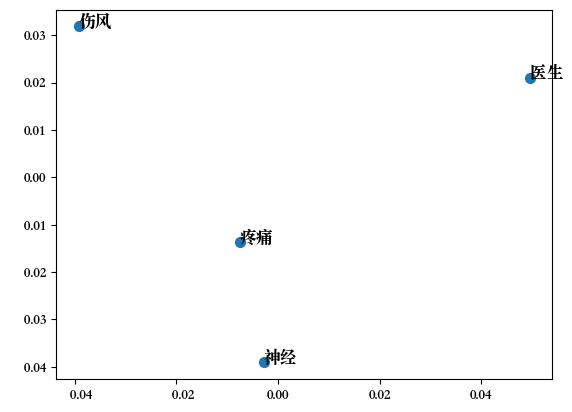

In [41]:
# 可视化词向量
words = ['医生', '疼痛', '神经', '伤风']
vectors = [model.wv[word] for word in words]
from sklearn.decomposition import PCA  # 语义空间降维，用于展示词语在二维空间的相对位置
from matplotlib import font_manager  # 用于设置中文字体显示
font_path = '/System/Library/Fonts/Supplemental/Songti.ttc' # 指定中文字体路径（根据系统修改）
prop = font_manager.FontProperties(fname = font_path)  # 创建字体属性对象
plt.rcParams['font.family'] = prop.get_name()    # 设置全局字体属性
# 使用PCA降维
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(vectors)  
import matplotlib.pyplot as plt  # 画图
# 取PCA降维结果中所有行的第一列和第二列数据绘制散点图，设置点的大小为50
plt.scatter(pca_result[:, 0], pca_result[:, 1], s = 50)

for i, word in enumerate(words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontproperties = prop, fontsize = 12)

plt.show()

Word2Vec损失分析

/var/folders/5n/3vzzg7zn6p93tcm8vtx98j_80000gn/T/ipykernel_2486/2731629474.py:48: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  plt.tight_layout()


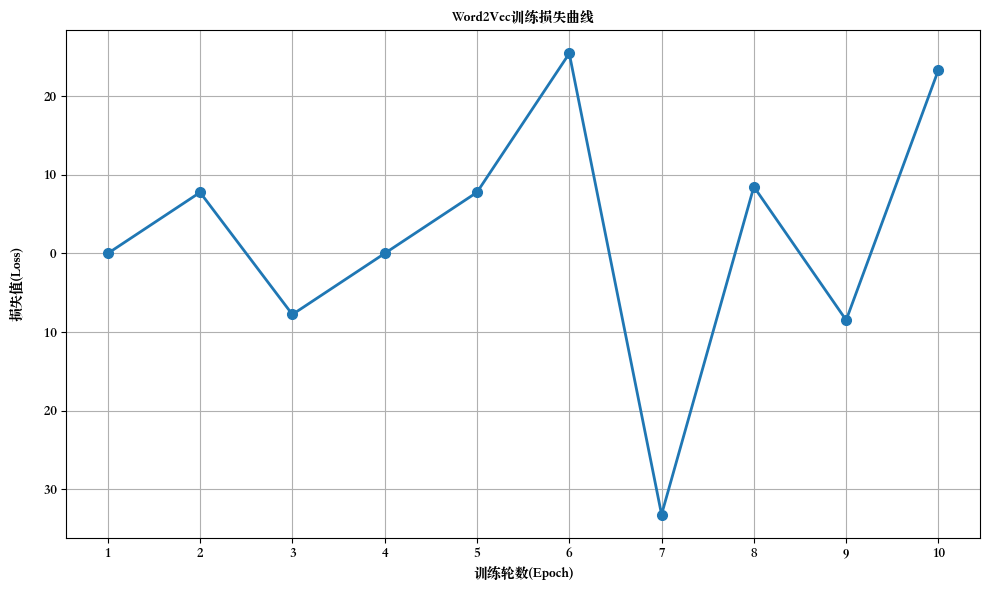


最终模型信息：
词汇表大小：16


In [42]:
#损失计算
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
#指定字体
font_path = '/System/Library/Fonts/Supplemental/Songti.ttc'
# 初始化模型（注意：不要设置 epochs，这里我们手动控制）
model = Word2Vec(
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    compute_loss=True
)  
# 构建词汇表
model.build_vocab(corpus)

# 手动逐轮训练并记录损失
losses = []
previous_loss = 0
epochs = 10

for epoch in range(epochs):
    model.train(
        corpus,
        total_examples=model.corpus_count,
        epochs=1,
        compute_loss=True
    )
    current_loss = model.get_latest_training_loss()
    epoch_loss = current_loss - previous_loss
    losses.append(epoch_loss)
    previous_loss = current_loss
## 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, 'o-',  color='#1f77b4',  # 主色：蓝色
    linewidth=2,          # 线条宽度
    markersize=7,         # 标记点大小
    label='Training Loss' # 添加图例标签
)
from matplotlib.font_manager import FontProperties  # Import FontProperties for custom fonts
font_prop = FontProperties(fname=font_path)  # Create a FontProperties object with the specified font path

plt.title('Word2Vec训练损失曲线', fontproperties=font_prop)
plt.xlabel('训练轮数(Epoch)', fontproperties=font_prop)
plt.ylabel('损失值(Loss)', fontproperties=font_prop)
plt.grid(True)
plt.xticks(range(1, epochs + 1))
plt.tight_layout()

plt.show()

## 打印最终模型的一些信息
print("\n最终模型信息：")
print(f"词汇表大小：{len(model.wv.key_to_index)}")